# FINM 35000 Problem Set 3: Equity Valuation Stress Testing

<span style="color:blue">Aman Krishna </span> <br>
<br>
<span style="color:#406A5F">Tim Taylor </span> <br>
<br>
<span style="color:purple">Yazmin Ramirez Delgado </span>

In [203]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import math as m 
from arch import arch_model
from arch.univariate import GARCH, EWMAVariance 
from sklearn import linear_model
import scipy.stats as stats
from statsmodels.regression.rolling import RollingOLS
import seaborn as sns
import warnings
from scipy.stats import norm
pd.set_option("display.precision", 2)
pd.set_option('display.float_format', '{:.3f}'.format)
warnings.filterwarnings("ignore")

## Stress testing an equity portfolio (100 points)

Project market value changes of an equity portfolio from time0 to time1 based on the changes in the macroeconomic variables (MEVs) from the severely adverse economic domestic scenario of the Federal Reserve’s Comprehensive Capital Analysis and Review (CCAR) 2021. Time0 is 12/31/2020 and time1 is 12/31/2021.

To make the projections, you may need to map the changes of MEVs from time0 to time1 to the change in values of the stocks from time0 to time1. In addition to the scenario given above,

    - Investment instruments: a portfolio of 20 stocks, 10 million shares in each stock.
    - Additional scenarios and historical data of the MEVs in the Fed scenarios. The Federal Reserve also provide scenario description narratives.
    - Equity and Fama-French factor historical data (total returns), ‘returns’ tab in wrds_data.xlsx

## 1. Build three projection models then compare the approaches and project the changes in the portfolio’s value: CAPM, Fama-French, and a “general multi-factor” model. You are required to provide support for your modeling choices where applicable (segmentation3, variable selection, choice(s) of historical data window, etc.). Your report should provide a clear picture of the modeling development process and modeling choices:


   1. i. Outline your steps in developing each model.
   2. ii. Describe your data processing procedures for missing data, data quality and if any, variable transformation. Provide justification if it’s necessary to use data outside of the data files from the assignment and the data files underlying the links in this document.
   3. iii. Demonstrate your variable selection process in each model supported by economic reasoning based on your understanding in the MEVs.
   4. iv. State the data window for each of your regression model. Perform your regressions using two data sets as if you were doing this homework twice- data from all times and data from only the “stressed times”,4 or else? How do different data choices affect your regression coefficients and forecasts?
   5. v. Define and support the granularity of your modeling. You can model and make projections at the individual stock level, or at the segment level (e.g., industry groups, or by stock style (growth versus value), etc.), or at the portfolio level.
   6. vi. If model at the segment or portfolio level, you may need to construct a synthetic time series for the segment or portfolio returns. The total returndata of each stock goes back to as far as 1963. However, the market weight data of each stock does not go back that far (see ‘prices’ tab in wrds_data.xlsx). Use judgment or arbitrarily assign weights when constructing the synthetic portfolio total return time series.
   7. vii. Provide rationale for your selection(s) of the equity market variable, the MEVs, and the time window of historical data used in the regressions. For example, the data file, wrds_data.xlsx (‘returns’ tab), contains historical equity and market data for CAPM and Fama-French. The Fed historical data also contains equity market data. (Hint: You may need to choose an equity market index from different sources)
   8. viii. Perform stationarity test(s) on the MEVs and transform the data if necessary and, in your own words, discuss stationarity testing is necessary in your modeling process.
   9. ix. In the stress test, you will need to build a two-step regression for the 3-factor Fama-French model. In the first step, regress Fama-French factors as functions of the MEVs in the Fed scenario. In the second step, combine your regressions into the Fama-French model and project the time1 portfolio value in the scenario.
   10. x. The general multi-factor model (GMF): Model the equity portfolio’s scenariovalues directly as a function of the MEVs provided in the Fed scenario and project the time1 portfolio value in the scenario.
   11. xi. Conduct performance testing for each model. You may need to use thesetests to guide yourself to go through an iterative process to improve model performance:
       1.  • Goodness of fit.
       2.  • Residual analysis.
       3.  • At least one more test to support the robustness of your models.
   12. xii. Finally the forecast portion in your report should contain a summary of projection outcomes (%return and $value change) from the three modeling approaches (i.e., CAPM, Fama French, and GMF).

>Given the observed data, we are going to separate the models in the following way:
>
>For CAPM and FAMA FRENCH, we are going to use monthly returns data since the data is available at that frequency
>
>On the other hand for the models using MEVs, we are going to use quarterly frequency as per data availability.

In [224]:
# Load the data
wrds_data = pd.read_excel('wrds_data-1.xlsx', sheet_name='returns')
#Change Date column fromth format "YYYY-MM" to datetime
wrds_data['Date'] = pd.to_datetime(wrds_data['Date'], format='%Y-%m')
#remove the columns after "WALMART INC"
wrds_data = wrds_data.iloc[:,0:28]

#Calculate excess return for each stock starting column 8. The risk free rate is in column 4
wrds_data.iloc[:,8:] = wrds_data.iloc[:,8:].sub(wrds_data.iloc[:,4], axis=0)

#Resample the data to quarterly with the first day of the quarter as the date
wrds_data_q = wrds_data.set_index('Date').resample('QS').first().reset_index()
wrds_data_q.head()

,Date,MKT COMPOSITE RETURN,S&P RETURN,FAMA-FRENCH MARKET FACTOR,RISK-FREE RATE,FAMA-FRENCH SIZE FACTOR (SMB),FAMA-FRENCH VALUE FACTOR (HML),MOMENTUM FACTOR,BIOGEN INC,JOHNSON & JOHNSON,...,ARCHER-DANIELS-MIDLAND CO,CONAGRA BRANDS INC,COLGATE-PALMOLIVE CO,CAMPBELL SOUP CO,KELLOGG CO,KRAFT HEINZ CO,COCA-COLA CO,PROCTER & GAMBLE CO,TYSON FOODS INC -CL A,WALMART INC
0,1963-01-01,NaN,0.049,0.049,0.003,0.031,0.022,-0.021,NaN,0.100,...,NaN,NaN,0.070,0.091,0.149,NaN,0.056,0.031,NaN,NaN
1,1963-04-01,NaN,0.049,0.045,0.003,-0.013,0.010,-0.001,NaN,0.009,...,NaN,NaN,0.043,0.001,-0.055,NaN,-0.013,0.054,NaN,NaN
2,1963-07-01,NaN,-0.004,-0.004,0.003,-0.005,-0.009,0.010,NaN,-0.005,...,NaN,NaN,-0.003,0.036,0.062,NaN,0.016,-0.030,NaN,NaN
3,1963-10-01,NaN,0.032,0.025,0.003,-0.006,-0.000,0.031,NaN,0.157,...,NaN,NaN,-0.088,0.013,0.070,NaN,0.012,0.005,NaN,NaN
4,1964-01-01,NaN,0.027,0.022,0.003,-0.002,0.015,0.011,NaN,0.029,...,NaN,NaN,-0.038,-0.028,-0.026,NaN,0.019,0.031,NaN,NaN


In [225]:
#Read the wrds_data file and create a map to tickers
wrds_ticker = pd.read_excel('wrds_data-1.xlsx', sheet_name='returns')
wrds_ticker = wrds_ticker.iloc[:,30:].dropna()
#drop 2nd column
wrds_ticker = wrds_ticker.drop(wrds_ticker.columns[1], axis=1)
#Rename 'ELI LILLY & CO' to 'LILLY (ELI) & CO'
wrds_ticker = wrds_ticker.replace({'ELI LILLY & CO':'LILLY (ELI) & CO'})
#Rename 'MERCK & CO. INC.' to 'MERCK & CO'
wrds_ticker = wrds_ticker.replace({'MERCK & CO. INC.':'MERCK & CO'})
#Rename 'KRAFT HEINZ CO/THE' to 'KRAFT HEINZ CO'
wrds_ticker = wrds_ticker.replace({'KRAFT HEINZ CO/THE':'KRAFT HEINZ CO'})
#Rename 'COCA-COLA CO/THE' to 'COCA-COLA CO'
wrds_ticker = wrds_ticker.replace({'COCA-COLA CO/THE':'COCA-COLA CO'})
#Rename 'PROCTER & GAMBLE CO/THE' to 'PROCTER & GAMBLE CO'
wrds_ticker = wrds_ticker.replace({'PROCTER & GAMBLE CO/THE':'PROCTER & GAMBLE CO'})
#Rename 'TYSON FOODS INC-CL A' to 'TYSON FOODS INC  -CL A'
wrds_ticker = wrds_ticker.replace({'TYSON FOODS INC-CL A':'TYSON FOODS INC  -CL A'})
#Create  dictionary with Name as key and Ticker as value
wrds_ticker = wrds_ticker.set_index('Name').to_dict()['Ticker']
wrds_ticker

{'BIOGEN INC': 'BIIB',
 'JOHNSON & JOHNSON': 'JNJ',
 'LILLY (ELI) & CO': 'LLY',
 'MERCK & CO': 'MRK',
 'PFIZER INC': 'PFE',
 'BANK OF AMERICA CORP': 'BAC',
 'CITIGROUP INC': 'C',
 'GOLDMAN SACHS GROUP INC': 'GS',
 'JPMORGAN CHASE & CO': 'JPM',
 'MORGAN STANLEY': 'MS',
 'ARCHER-DANIELS-MIDLAND CO': 'ADM',
 'CONAGRA BRANDS INC': 'CAG',
 'COLGATE-PALMOLIVE CO': 'CL',
 'CAMPBELL SOUP CO': 'CPB',
 'KELLOGG CO': 'K',
 'KRAFT HEINZ CO': 'KHC',
 'COCA-COLA CO': 'KO',
 'PROCTER & GAMBLE CO': 'PG',
 'TYSON FOODS INC  -CL A': 'TSN',
 'WALMART INC': 'WMT'}

In [226]:
for i in wrds_data.columns[8:]:
    #use the key to replace the column name
    wrds_data = wrds_data.rename(columns={i: wrds_ticker[i]})
    wrds_data_q = wrds_data_q.rename(columns={i: wrds_ticker[i]})
wrds_data.head()

,Date,MKT COMPOSITE RETURN,S&P RETURN,FAMA-FRENCH MARKET FACTOR,RISK-FREE RATE,FAMA-FRENCH SIZE FACTOR (SMB),FAMA-FRENCH VALUE FACTOR (HML),MOMENTUM FACTOR,BIIB,JNJ,...,ADM,CAG,CL,CPB,K,KHC,KO,PG,TSN,WMT
0,1963-01-01,NaN,0.049,0.049,0.003,0.031,0.022,-0.021,NaN,0.100,...,NaN,NaN,0.070,0.091,0.149,NaN,0.056,0.031,NaN,NaN
1,1963-02-01,NaN,-0.029,-0.024,0.002,0.005,0.022,0.025,NaN,0.017,...,NaN,NaN,-0.002,-0.106,-0.062,NaN,-0.005,-0.033,NaN,NaN
2,1963-03-01,NaN,0.035,0.031,0.002,-0.026,0.021,0.016,NaN,0.001,...,NaN,NaN,0.070,0.010,0.097,NaN,0.044,0.040,NaN,NaN
3,1963-04-01,NaN,0.049,0.045,0.003,-0.013,0.010,-0.001,NaN,0.009,...,NaN,NaN,0.043,0.001,-0.055,NaN,-0.013,0.054,NaN,NaN
4,1963-05-01,NaN,0.014,0.018,0.002,0.011,0.025,0.004,NaN,0.049,...,NaN,NaN,0.008,0.019,0.096,NaN,0.003,-0.018,NaN,NaN


In [227]:
# Remove all the rows before 1999-06
wrds_data = wrds_data[wrds_data['Date'] >= '1999-06']
wrds_data_q = wrds_data_q[wrds_data_q['Date'] >= '1999-06']
wrds_data.reset_index(drop=True, inplace=True)
wrds_data_q.reset_index(drop=True, inplace=True)
wrds_data.head()

,Date,MKT COMPOSITE RETURN,S&P RETURN,FAMA-FRENCH MARKET FACTOR,RISK-FREE RATE,FAMA-FRENCH SIZE FACTOR (SMB),FAMA-FRENCH VALUE FACTOR (HML),MOMENTUM FACTOR,BIIB,JNJ,...,ADM,CAG,CL,CPB,K,KHC,KO,PG,TSN,WMT
0,1999-06-01,0.042,0.054,0.048,0.004,0.032,-0.034,0.049,0.524,0.054,...,0.025,0.018,-0.018,0.044,-0.053,NaN,-0.097,-0.048,-0.026,0.129
1,1999-07-01,-0.034,-0.032,-0.035,0.004,0.025,-0.005,0.015,0.282,-0.075,...,-0.101,-0.037,0.002,-0.050,0.051,NaN,-0.027,0.015,-0.173,-0.128
2,1999-08-01,-0.022,-0.006,-0.014,0.004,-0.010,-0.017,0.029,0.278,0.122,...,-0.021,-0.045,0.080,0.000,0.025,NaN,-0.016,0.092,-0.142,0.045
3,1999-09-01,-0.032,-0.029,-0.028,0.004,0.034,-0.034,0.065,-0.264,-0.105,...,-0.071,-0.083,-0.149,-0.118,0.049,NaN,-0.194,-0.059,0.019,0.071
4,1999-10-01,0.055,0.062,0.061,0.004,-0.068,-0.032,0.055,0.232,0.136,...,0.006,0.151,0.322,0.152,0.059,NaN,0.219,0.118,-0.076,0.188


> We chose the June, 1999 date as the start of our dataset to take into account the data availability for the 20 equities provided in this exercise. On June, 1999 all but one (Kraft Heinz Co) have return data available.
> 
> Moreover >20 years of monthly data is a reasonable amount of data to use for our analysis.

In [228]:
#Backfill the missing values
wrds_data = wrds_data.fillna(method='bfill')
wrds_data_q = wrds_data_q.fillna(method='bfill')
wrds_data.head()

,Date,MKT COMPOSITE RETURN,S&P RETURN,FAMA-FRENCH MARKET FACTOR,RISK-FREE RATE,FAMA-FRENCH SIZE FACTOR (SMB),FAMA-FRENCH VALUE FACTOR (HML),MOMENTUM FACTOR,BIIB,JNJ,...,ADM,CAG,CL,CPB,K,KHC,KO,PG,TSN,WMT
0,1999-06-01,0.042,0.054,0.048,0.004,0.032,-0.034,0.049,0.524,0.054,...,0.025,0.018,-0.018,0.044,-0.053,-0.086,-0.097,-0.048,-0.026,0.129
1,1999-07-01,-0.034,-0.032,-0.035,0.004,0.025,-0.005,0.015,0.282,-0.075,...,-0.101,-0.037,0.002,-0.050,0.051,-0.086,-0.027,0.015,-0.173,-0.128
2,1999-08-01,-0.022,-0.006,-0.014,0.004,-0.010,-0.017,0.029,0.278,0.122,...,-0.021,-0.045,0.080,0.000,0.025,-0.086,-0.016,0.092,-0.142,0.045
3,1999-09-01,-0.032,-0.029,-0.028,0.004,0.034,-0.034,0.065,-0.264,-0.105,...,-0.071,-0.083,-0.149,-0.118,0.049,-0.086,-0.194,-0.059,0.019,0.071
4,1999-10-01,0.055,0.062,0.061,0.004,-0.068,-0.032,0.055,0.232,0.136,...,0.006,0.151,0.322,0.152,0.059,-0.086,0.219,0.118,-0.076,0.188


Since one of the firms did not have data available for the entire period, we decided to backfill the data for the missing dates with the last available data point.

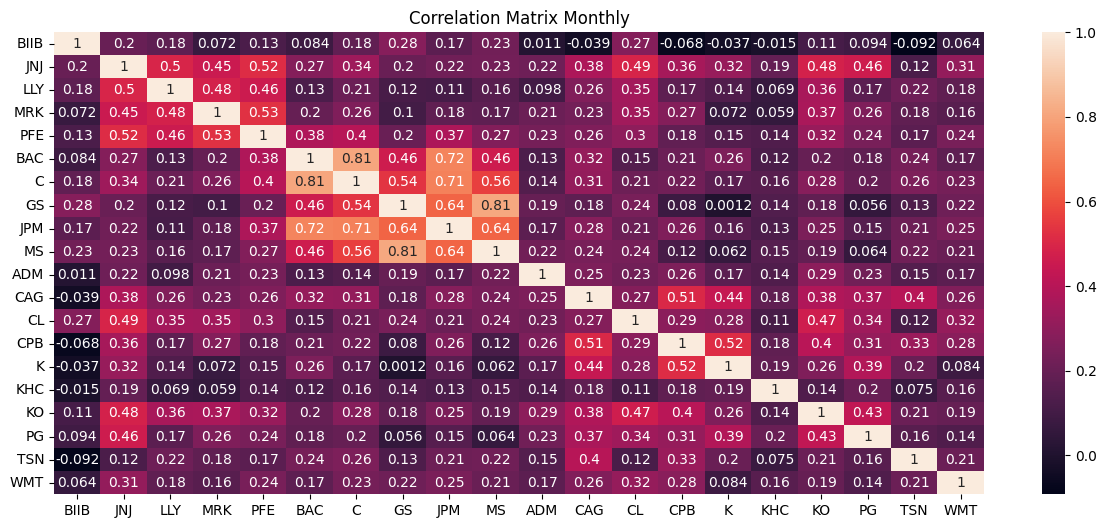

In [229]:
#Create a correlation matrix and color code  using seaborn
corr = wrds_data.iloc[:,8:].corr()
plt.figure(figsize=(15,6))
sns.heatmap(corr, annot=True)
plt.title('Correlation Matrix Monthly')
plt.show()

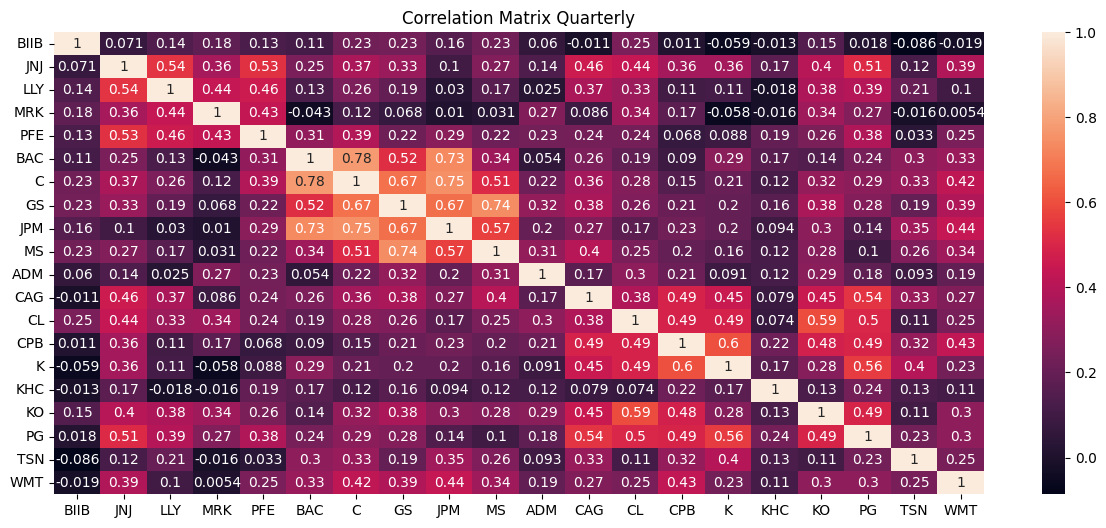

In [230]:
#Create a correlation matrix and color code  using seaborn
corr = wrds_data_q.iloc[:,8:].corr()
plt.figure(figsize=(15,6))
sns.heatmap(corr, annot=True)
plt.title('Correlation Matrix Quarterly')
plt.show()

> We see that three of the banks BOA, Citi and JPMC are highly correlated with each other based on their 20 year history of monthly returns. Goldman is surprisingly not as correlated with the other banks. This is likely due to the fact that Goldman is more of an investment bank than a commercial bank.
>
> To reinforce this point, we see that Goldman is more correlated with Morgan Stanley than with the other banks.

>The Clustering is based on Quarterly data to make it comparable at a later stage with the other two models (CAPM & FF).

In [231]:
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform

distance_matrix = 1 - corr

# Perform hierarchical/agglomerative clustering
linked = linkage(squareform(distance_matrix), 'complete')

threshold_distance = 1 - 0.36  # Since we're interested in correlation greater than 0.36
clusters = fcluster(linked, threshold_distance, criterion='distance')

# Map the cluster labels back to stock names
stock_names = corr.columns.tolist()
clustered_stocks = {stock: cluster for stock, cluster in zip(stock_names, clusters)}

# Group stocks by their cluster label
grouped_stocks = {}
for stock, cluster_label in clustered_stocks.items():
    grouped_stocks.setdefault(cluster_label, []).append(stock)

# Output the groups
for cluster, stocks in grouped_stocks.items():
    print(f"Cluster {cluster}: {stocks}")

Cluster 2: ['BIIB']
Cluster 1: ['JNJ', 'LLY', 'MRK', 'PFE']
Cluster 4: ['BAC', 'C', 'JPM']
Cluster 3: ['GS', 'MS']
Cluster 8: ['ADM']
Cluster 9: ['CAG', 'CPB', 'K', 'PG']
Cluster 7: ['CL', 'KO']
Cluster 6: ['KHC']
Cluster 10: ['TSN']
Cluster 5: ['WMT']


In [232]:
def convert_to_datetime(quarterly_date):
    year, quarter = quarterly_date.split(' Q')
    year = int(year)
    quarter = int(quarter)
    
    # Calculate the month by mapping quarter to months (e.g., Q1 -> January)
    month = 3 * quarter - 2
    
    # Create a datetime object with the year and month
    return pd.to_datetime(f'{year}-{month:02d}')


In [233]:
# Loading the MEVs
df1 = pd.read_csv('2021-table_1b_historic_international.csv')
df2 = pd.read_csv('2021-table_1a_historic_domestic.csv')

# Drop the Scenario Name column
df1 = df1.drop(columns=['Scenario Name'])
df2 = df2.drop(columns=['Scenario Name'])

df1['Date'] = df1['Date'].apply(convert_to_datetime)
df2['Date'] = df2['Date'].apply(convert_to_datetime)

In [234]:
#Check shape before merging
df1.shape, df2.shape

((180, 13), (180, 17))

In [235]:
# Merge the two dataframes
df_mev = pd.merge(df1, df2, on=['Date'], how='outer')

In [236]:
#Start from 1999-06
df_mev = df_mev[df_mev['Date'] >= '1999-06']
df_mev.reset_index(drop=True, inplace=True)
df_mev.head()

,Date,Euro area real GDP growth,Euro area inflation,Euro area bilateral dollar exchange rate (USD/euro),Developing Asia real GDP growth,Developing Asia inflation,"Developing Asia bilateral dollar exchange rate (F/USD, index)",Japan real GDP growth,Japan inflation,Japan bilateral dollar exchange rate (yen/USD),...,3-month Treasury rate,5-year Treasury yield,10-year Treasury yield,BBB corporate yield,Mortgage rate,Prime rate,Dow Jones Total Stock Market Index (Level),House Price Index (Level),Commercial Real Estate Price Index (Level),Market Volatility Index (Level)
0,1999-07-01,4.800,2.000,1.064,8.300,1.300,102.500,2.100,-0.300,106.800,...,4.700,5.900,6.200,7.800,7.800,8.100,11713.800,97.700,127.000,28.500
1,1999-10-01,4.700,1.800,1.007,10.500,2.300,100.900,0.100,-0.800,102.200,...,5.000,6.100,6.500,8.000,7.800,8.400,13812.700,99.800,130.100,28.800
2,2000-01-01,4.900,2.600,0.957,7.300,1.500,100.000,7.000,-0.500,102.700,...,5.500,6.600,6.700,8.300,8.300,8.700,14296.200,102.300,127.200,27.000
3,2000-04-01,3.600,0.900,0.955,6.900,-0.300,100.700,1.900,-1.100,106.100,...,5.700,6.500,6.400,8.600,8.300,9.200,13618.500,104.900,126.100,33.500
4,2000-07-01,2.200,3.400,0.884,7.800,2.200,101.400,0.100,-0.300,107.900,...,6.000,6.100,6.100,8.200,8.000,9.500,13613.300,107.200,139.300,21.900


In [237]:
#Check shape of wrds_data and df_mev
wrds_data.shape, wrds_data_q.shape, df_mev.shape

((259, 28), (86, 28), (86, 29))

## CAPM MODEL

In [238]:
# Drop Columns 2:8
capm_data = wrds_data.drop(wrds_data.columns[2:8], axis=1)
capm_data

,Date,MKT COMPOSITE RETURN,BIIB,JNJ,LLY,MRK,PFE,BAC,C,GS,...,ADM,CAG,CL,CPB,K,KHC,KO,PG,TSN,WMT
0,1999-06-01,0.042,0.524,0.054,-0.001,0.089,0.015,0.136,0.071,0.059,...,0.025,0.018,-0.018,0.044,-0.053,-0.086,-0.097,-0.048,-0.026,0.129
1,1999-07-01,-0.034,0.282,-0.075,-0.087,-0.085,-0.071,-0.098,-0.063,-0.114,...,-0.101,-0.037,0.002,-0.050,0.051,-0.086,-0.027,0.015,-0.173,-0.128
2,1999-08-01,-0.022,0.278,0.122,0.136,-0.010,0.113,-0.092,-0.007,-0.072,...,-0.021,-0.045,0.080,0.000,0.025,-0.086,-0.016,0.092,-0.142,0.045
3,1999-09-01,-0.032,-0.264,-0.105,-0.144,-0.035,-0.054,-0.076,-0.014,0.016,...,-0.071,-0.083,-0.149,-0.118,0.049,-0.086,-0.194,-0.059,0.019,0.071
4,1999-10-01,0.055,0.232,0.136,0.069,0.224,0.102,0.153,0.232,0.162,...,0.006,0.151,0.322,0.152,0.059,-0.086,0.219,0.118,-0.076,0.188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254,2020-08-01,0.047,0.047,0.059,-0.008,0.063,-0.018,0.034,0.022,0.041,...,0.053,0.030,0.027,0.061,0.036,0.031,0.048,0.055,0.029,0.077
255,2020-09-01,-0.026,-0.014,-0.030,-0.003,-0.020,-0.029,-0.057,-0.157,-0.019,...,0.039,-0.069,-0.027,-0.081,-0.089,-0.145,0.005,0.005,-0.053,0.007
256,2020-10-01,-0.021,-0.112,-0.079,-0.119,-0.093,-0.033,-0.016,-0.028,-0.060,...,-0.006,-0.010,0.028,-0.028,-0.026,0.021,-0.027,-0.008,-0.038,-0.008
257,2020-11-01,0.127,-0.047,0.062,0.122,0.069,0.144,0.188,0.330,0.220,...,0.084,0.042,0.085,0.072,0.025,0.090,0.082,0.013,0.147,0.101


In [239]:
#Create a dataframe to store the betas, alphas and r-squared values for each cluster/regression
capm_data_summary = pd.DataFrame(columns=['Cluster','Beta','Alpha','R-Squared'])

X = capm_data['MKT COMPOSITE RETURN']

for cluster,stocks in grouped_stocks.items():
    #Run a OLS regression for each cluster against the market (column 1 of capm_data)
    y = capm_data[stocks].mean(axis=1)
    X = sm.add_constant(X)
    model = sm.OLS(y,X)
    results = model.fit()
    #Store the results in the dataframe
    capm_data_summary = capm_data_summary.append({'Cluster':str(stocks),'Beta':results.params[1],'Alpha':results.params[0],'R-Squared':results.rsquared}, ignore_index=True)
capm_data_summary

,Cluster,Beta,Alpha,R-Squared
0,['BIIB'],0.606,0.018,0.040
1,"['JNJ', 'LLY', 'MRK', 'PFE']",0.561,0.003,0.257
2,"['BAC', 'C', 'JPM']",1.609,-0.001,0.522
3,"['GS', 'MS']",1.569,0.002,0.550
4,['ADM'],0.686,0.006,0.144
5,"['CAG', 'CPB', 'K', 'PG']",0.426,0.003,0.178
6,"['CL', 'KO']",0.510,0.003,0.232
7,['KHC'],0.253,-0.067,0.040
8,['TSN'],0.776,0.005,0.133
9,['WMT'],0.396,0.005,0.091


## FAMA FRENCH MODEL

In [240]:
# Drop columns 1:3 and column 7
ff_data = wrds_data.drop(wrds_data.columns[1:3], axis=1)
ff_data = ff_data.drop(ff_data.columns[5], axis=1)
ff_data = ff_data.drop(ff_data.columns[2], axis=1)
ff_data

,Date,FAMA-FRENCH MARKET FACTOR,FAMA-FRENCH SIZE FACTOR (SMB),FAMA-FRENCH VALUE FACTOR (HML),BIIB,JNJ,LLY,MRK,PFE,BAC,...,ADM,CAG,CL,CPB,K,KHC,KO,PG,TSN,WMT
0,1999-06-01,0.048,0.032,-0.034,0.524,0.054,-0.001,0.089,0.015,0.136,...,0.025,0.018,-0.018,0.044,-0.053,-0.086,-0.097,-0.048,-0.026,0.129
1,1999-07-01,-0.035,0.025,-0.005,0.282,-0.075,-0.087,-0.085,-0.071,-0.098,...,-0.101,-0.037,0.002,-0.050,0.051,-0.086,-0.027,0.015,-0.173,-0.128
2,1999-08-01,-0.014,-0.010,-0.017,0.278,0.122,0.136,-0.010,0.113,-0.092,...,-0.021,-0.045,0.080,0.000,0.025,-0.086,-0.016,0.092,-0.142,0.045
3,1999-09-01,-0.028,0.034,-0.034,-0.264,-0.105,-0.144,-0.035,-0.054,-0.076,...,-0.071,-0.083,-0.149,-0.118,0.049,-0.086,-0.194,-0.059,0.019,0.071
4,1999-10-01,0.061,-0.068,-0.032,0.232,0.136,0.069,0.224,0.102,0.153,...,0.006,0.151,0.322,0.152,0.059,-0.086,0.219,0.118,-0.076,0.188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254,2020-08-01,0.076,-0.003,-0.029,0.047,0.059,-0.008,0.063,-0.018,0.034,...,0.053,0.030,0.027,0.061,0.036,0.031,0.048,0.055,0.029,0.077
255,2020-09-01,-0.036,0.001,-0.025,-0.014,-0.030,-0.003,-0.020,-0.029,-0.057,...,0.039,-0.069,-0.027,-0.081,-0.089,-0.145,0.005,0.005,-0.053,0.007
256,2020-10-01,-0.021,0.044,0.040,-0.112,-0.079,-0.119,-0.093,-0.033,-0.016,...,-0.006,-0.010,0.028,-0.028,-0.026,0.021,-0.027,-0.008,-0.038,-0.008
257,2020-11-01,0.125,0.055,0.021,-0.047,0.062,0.122,0.069,0.144,0.188,...,0.084,0.042,0.085,0.072,0.025,0.090,0.082,0.013,0.147,0.101


In [241]:
#Create a dataframe to store the betas, alphas and r-squared values for each cluster/regression
ff_data_summary = pd.DataFrame(columns=['Cluster','Beta','Alpha','R-Squared'])

X = ff_data.iloc[:,1:4]

for cluster,stocks in grouped_stocks.items():
    #Run a OLS regression for each cluster against the market (column 1 of ff_data)
    y = ff_data[stocks].mean(axis=1)
    X = sm.add_constant(X)
    model = sm.OLS(y,X)
    results = model.fit()
    #Store the results in the dataframe
    ff_data_summary = ff_data_summary.append({'Cluster':str(stocks),'Beta':results.params[1],'Alpha':results.params[0],'R-Squared':results.rsquared}, ignore_index=True)
ff_data_summary

,Cluster,Beta,Alpha,R-Squared
0,['BIIB'],0.642,0.014,0.166
1,"['JNJ', 'LLY', 'MRK', 'PFE']",0.576,0.004,0.320
2,"['BAC', 'C', 'JPM']",1.558,-0.003,0.649
3,"['GS', 'MS']",1.571,-0.001,0.598
4,['ADM'],0.609,0.007,0.143
5,"['CAG', 'CPB', 'K', 'PG']",0.419,0.004,0.244
6,"['CL', 'KO']",0.535,0.004,0.279
7,['KHC'],0.331,-0.067,0.068
8,['TSN'],0.706,0.005,0.150
9,['WMT'],0.510,0.005,0.184


## 2. Model risk assessment and controls
    1. i. Outcome analysis to substantiate the reasonableness of the projection outcomes
       1. • Back-test your portfolio value projections and discuss the reliability of each modeling approach based on the projections.
       2. • Discuss the benchmarking results by comparing the reasonableness of each model’s projections. Which model performs the best? Why?
    2. ii. Discuss the potential model risks as the sources of uncertainties in the forecasting process
       1. • Model complexity and interpretability
       2. • Discuss how model search might cause uncertainties in the forecasts
       3. • Which model is more prone to the Law of Small Numbers? Why?

## 3. Repeat necessary steps in 1 and 2 for the supervisory baseline domestic scenario.

Compare the forecasting results from the two scenarios.